# Tema 9: Combinación Lineal de Unitarias


En este notebook vamos a implementar la técnica de Combinación Lineal de Unitarias (Linear Combination of Unitaries, LCU). Esta técnica es fundamental en computación cuántica para construir operadores complejos a partir de operadores unitarios más simples.

La idea central del LCU es que podemos expresar un operador general como una suma ponderada de operadores unitarios. Matemáticamente, si tenemos un operador A que queremos implementar, podemos escribirlo como:

A = α₀U₀ + α₁U₁ + α₂U₂ + ... + αₘ₋₁Uₘ₋₁

donde cada Uᵢ es un operador unitario y cada αᵢ es un coeficiente complejo que representa la amplitud o peso de ese operador en la combinación lineal.

El algoritmo LCU utiliza qubits auxiliares (ancilla qubits) para preparar un estado que codifica estas amplitudes, y luego aplica los operadores unitarios de forma controlada según el estado de estos qubits auxiliares. Al final, mediante una medición selectiva y post-selección, podemos implementar efectivamente el operador deseado.

En este notebook exploraremos cómo construir estos circuitos cuánticos, cómo preparar los estados de amplitud necesarios, y cómo aplicar los operadores controlados para diferentes casos de uso.

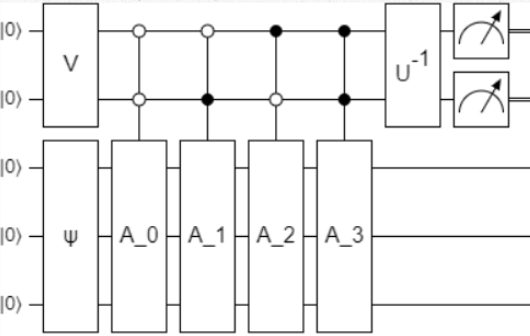

## Desarrollo Teórico del Algoritmo LCU
 
El algoritmo de Combinación Lineal de Unitarias (LCU) permite implementar un operador no unitario $A$ como una combinación lineal de operadores unitarios. Supongamos que queremos implementar:
 
$$A = \sum_{i=0}^{m-1} \alpha_i U_i$$
 
donde $U_i$ son operadores unitarios y $\alpha_i \in \mathbb{C}$ son coeficientes complejos. El objetivo es aplicar este operador a un estado cuántico $|\psi\rangle$.
 
**Paso 1: Normalización de coeficientes**
 
Primero, normalizamos los coeficientes definiendo:
 
$$\beta_i = \frac{\alpha_i}{\sum_{j=0}^{m-1} |\alpha_j|}$$
 
de modo que $\sum_{i=0}^{m-1} |\beta_i| = 1$. Entonces:
 
$$A = \left(\sum_{j=0}^{m-1} |\alpha_j|\right) \sum_{i=0}^{m-1} \beta_i U_i$$
 
**Paso 2: Preparación del estado auxiliar**
 
Utilizamos $\lceil \log_2(m) \rceil$ qubits auxiliares para codificar los índices de los operadores. Preparamos el estado:
 
$$|\phi\rangle = \sum_{i=0}^{m-1} \sqrt{|\beta_i|} e^{i\arg(\beta_i)} |i\rangle$$
 
Este estado codifica tanto las amplitudes como las fases de los coeficientes normalizados.
 
**Paso 3: Aplicación controlada de unitarias**
 
Aplicamos cada operador $U_i$ de forma controlada sobre el estado objetivo $|\psi\rangle$, condicionado al estado $|i\rangle$ de los qubits auxiliares:
 
$$\text{SELECT} = \sum_{i=0}^{m-1} |i\rangle\langle i| \otimes U_i$$
 
El estado resultante después de preparar $|\phi\rangle$ y aplicar SELECT es:
 
$$|\Psi\rangle = \text{SELECT} \cdot (|\phi\rangle \otimes |\psi\rangle) = \sum_{i=0}^{m-1} \sqrt{|\beta_i|} e^{i\arg(\beta_i)} |i\rangle \otimes U_i|\psi\rangle$$
 
**Paso 4: Post-selección**
 
Finalmente, aplicamos la operación inversa de preparación del estado auxiliar y medimos los qubits auxiliares. Si obtenemos el resultado $|0\rangle$ (lo cual ocurre con probabilidad $p = \frac{\|A|\psi\rangle\|^2}{\left(\sum_j |\alpha_j|\right)^2}$), el estado resultante en los qubits objetivo es:
 
$$|\psi'\rangle = \frac{A|\psi\rangle}{\|A|\psi\rangle\|}$$
 
Este es precisamente el estado que resulta de aplicar el operador $A$ (salvo normalización).
 
**Complejidad del algoritmo**
 
La probabilidad de éxito de la post-selección depende de la norma del operador $A$ y del estado $|\psi\rangle$. Para mejorar la probabilidad de éxito, se pueden utilizar técnicas de amplificación de amplitud o repetir el proceso múltiples veces.

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from IPython.display import display

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener n qubits para el estado y m qubits para las amplitudes del LCU. Además, introduciremos una lista de operadores y otra de amplitudes de cada operador. El m se deduce de la longitud de estas listas.

In [2]:
def _preparar_estado_amplitudes(amplitudes: np.ndarray, qubits: list, circuit: QuantumCircuit, inverse: bool = False) -> None:
    """Prepara estado con amplitudes reales usando solo Ry/cry."""
    m = len(qubits)
    amps = np.array(amplitudes[: 2**m], dtype=float)
    amps = amps / np.linalg.norm(amps)

    sgn = -1 if inverse else 1
    eps = 1e-10

    if m == 1:
        # theta = 2 atan2(amp1, amp0)
        theta = sgn * 2 * np.arctan2(amps[1], amps[0])
        circuit.ry(theta, qubits[0])

    elif m == 2:
        a, b, c, d = amps[0], amps[1], amps[2], amps[3]

        # Normas de cada rama del control (|0·> y |1·>)
        n01 = np.hypot(a, b)
        n23 = np.hypot(c, d)

        # Ángulos robustos con atan2 (preservan signos)
        theta0 = sgn * 2 * np.arctan2(n23, n01)
        theta1 = sgn * 2 * np.arctan2(b, a) if n01 > eps else 0.0
        theta2 = sgn * 2 * np.arctan2(d, c) if n23 > eps else 0.0

        if inverse:
            if n23 > eps:
                circuit.cry(theta2, qubits[1], qubits[0])     # control=1
            if n01 > eps:
                circuit.x(qubits[1])                         # ahora control original=0
                circuit.cry(theta1, qubits[1], qubits[0])
                circuit.x(qubits[1])
            circuit.ry(theta0, qubits[1])
        else:
            circuit.ry(theta0, qubits[1])
            if n01 > eps:
                circuit.x(qubits[1])
                circuit.cry(theta1, qubits[1], qubits[0])
                circuit.x(qubits[1])
            if n23 > eps:
                circuit.cry(theta2, qubits[1], qubits[0])

    else:
        raise ValueError("Solo m=1 o m=2 sin transpilación.")

In [3]:
def LCU(n: int, operator_list: list, amplitudes_list: np.ndarray):
    # Obtenemos el m
    m = int(np.ceil(np.log2(len(amplitudes_list))))
    # Registros
    qr = QuantumRegister(n, "State")
    LCUr = QuantumRegister(m, "LCUr")

    # Circuito (devolvemos circuito, no gate, para evitar descomposición anidada)
    qc = QuantumCircuit(LCUr, qr, name="LCU")

    # Amplitudes de V, la raíz cuadrada de los módulos de las amplitudes
    amplitudesV = np.sqrt(np.abs(amplitudes_list))

    # Si faltan elementos, añadimos 0 al final
    if len(amplitudesV) != 2**m:
        amplitudesV = np.append(amplitudesV, np.zeros(2**m - len(amplitudesV)))

    # Preparamos los qubits LCU (solo Ry/cry, sin StatePreparation)
    _preparar_estado_amplitudes(amplitudesV, list(LCUr), qc, inverse=False)

    # Vamos aplicando de manera controlada las puertas
    for i in range(len(amplitudes_list)):
        # Para seleccionar los controles adecuados, ponemos X donde haya 0
        binario = bin(i)[2:]
        binario = ("0" * (m - len(binario)) + binario)[::-1]
        for j, bit in enumerate(binario):
            if bit == "0":
                qc.x(j)  # j es índice en LCUr (qubits 0..m-1 del circuito)
        
        # Añadir operador controlado
        controlled_op = operator_list[i]
        qc.append(controlled_op.control(len(list(LCUr))), list(LCUr) + list(qr))
        
        for j, bit in enumerate(binario):
            if bit == "0":
                qc.x(j)

    # Deshacemos la inicialización
    _preparar_estado_amplitudes(amplitudesV, list(LCUr), qc, inverse=True)

    return qc.to_gate()

Creamos dos unitarias de prueba. Estas serán $\mathbb{I}\otimes X$ y $X\otimes \mathbb{I}$. El operador total será:

$A = \frac{1}{3}\mathbb{I}\otimes X + \frac{2}{3}X\otimes \mathbb{I}$

In [4]:
n = 2
amplitudes_list = np.array([1/3,2/3])

unitary_circuit1 = QuantumCircuit(n, name='A1')
unitary_circuit2 = QuantumCircuit(n, name='A2')

unitary_circuit1.x(1)
unitary_circuit2.x(0)

unitary1 = unitary_circuit1.to_gate()
unitary2 = unitary_circuit2.to_gate()

operator_list = [unitary1, unitary2]

Veamos el circuito obtenido.

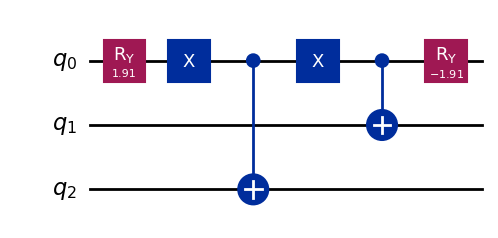

In [ ]:
qc = QuantumCircuit(n+1)
#Llamamos directamente a la puerta, sin necesidad de guardarla
qc.append(LCU(n,operator_list,amplitudes_list), range(n+1))

#Descomponemos para ver el circuito
qc2 = qc.decompose(['LCU'] + [f'cA{i+1}' for i in range(len(amplitudes_list))], reps=4)#qc.decompose(["LCU"], reps=1)

qc2.draw("mpl")

Vamos a aplicarla sobre un estado concreto y mediremos los dos primeros qubits para ver si obtenemos aquello que buscamos.

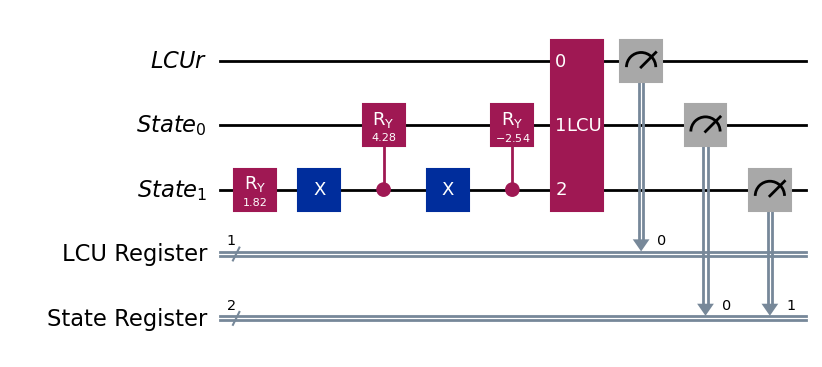

Circuito creado: 9 puertas, 3 qubits


In [6]:
# Empezamos en un estado cualquiera
state = np.array([-0.35, 0.55, 0.25, -0.8])
state /= np.linalg.norm(state)

# Circuito cuántico
qr = QuantumRegister(n, name="State")
LCUr = QuantumRegister(1, name="LCUr")

crState = ClassicalRegister(n, name="State Register")
crLCU = ClassicalRegister(1, name="LCU Register")

qc = QuantumCircuit(LCUr, qr, crLCU, crState, name="Circuit")

# Inicializamos el estado (evitar StatePreparation que puede colgar el kernel)
_preparar_estado_amplitudes(state, qr, qc)

# Aplicamos el LCU
qc.append(LCU(n, operator_list, amplitudes_list), LCUr[:] + qr[:])

# Medimos los qubits
qc.measure(LCUr, crLCU)
qc.measure(qr, crState)

display(qc.draw("mpl"))
# Usar print(qc) o qc.draw('text') si necesitas ver el circuito.
print(f"Circuito creado: {qc.size()} puertas, {qc.num_qubits} qubits")

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador. Importante: no uso transpilación porque Qiskit rompe el kernel por un motivo desconocido al ejecutar un circuito transpilado. Por esp lo hemos transpilado a mano.

In [7]:
#Número de shots
n_shots = 10000

#Simulador de n+m qubits
backend = AerSimulator()

# Comentado porque mata el kernel
#Transpilamos
# qc_transpiled = transpile(qc, backend)
#Creamos el job con más shots para más precisión
# job = backend.run(qc_transpiled, shots=n_shots)
# #Obtenemos el resultado y sus cuentas
# counts = job.result().get_counts()
# #Ploteamos los histogramas de resultados
# plot_histogram(counts)

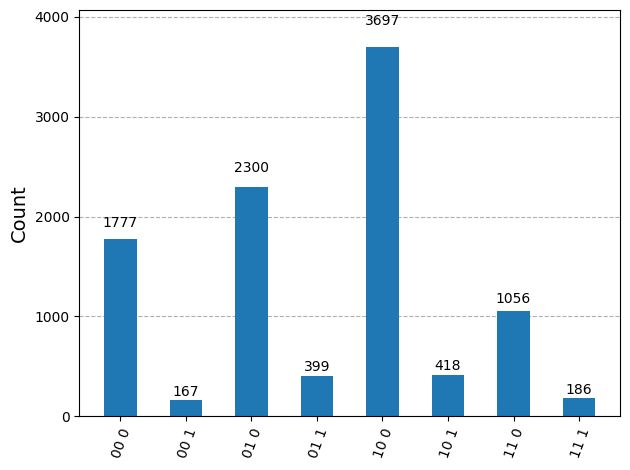

In [ ]:
qc_transpiled = qc.decompose(['LCU'] + [f'cA{i+1}' for i in range(len(amplitudes_list))], reps=4)
# Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()

#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos que si el qubit LCU está en 0, tenemos muchas cuentas, pero si está en 1, tenemos pocas. Recordemos que la probabilidad de obtener el 0 es dado por

$\langle A^2 \rangle$

In [9]:
#Creamos el operador A
X = np.array([[0,1],[1,0]])
A = amplitudes_list[0]*np.kron(X,np.eye(2)) + amplitudes_list[1]*np.kron(np.eye(2), X)

#Hacemos el valor esperado de su cuadrado
prob0 = state @ A@A @ state
print('Probabilidad de obtener 0 ', prob0)

#Calculamos con las cuentas
cuentas0 = [ counts[key] for key in counts if key[-1] == '0' ] #Cuentas si acabamos en 0
frec0 = sum(cuentas0)/n_shots

print('Frecuencia de obtener 0 ', frec0)

Probabilidad de obtener 0  0.8847006651884701
Frecuencia de obtener 0  0.883


Vemos que coinciden. Vamos a ver el estado después de aplicar el operador.

In [10]:
#Primero el estado teórico
new_state = A @ state

print('Probabilidades teóricas: ', new_state**2)

#Ahora el estado obtenido
state_0 = { key[:-2]: counts[key]/(n_shots) for key in counts if key[-1] == '0' } #Cuentas si acabamos en 0 normalizadas

vector_0 = np.zeros(2**n)

for i in state_0:
    vector_0[int(i,2)] = state_0[i]

print('Probabilidades obtenidas: ', vector_0)


Probabilidades teóricas:  [0.17960089 0.22172949 0.37472284 0.10864745]
Probabilidades obtenidas:  [0.1777 0.23   0.3697 0.1056]


Vemos que las probabilidaddes coinciden bien.

---
# Ejercicio

Haz la misma prueba con otros operadores con más qubits.